## Analysing moving average crossings

In [73]:
import pandas as pd
import plotly.graph_objects as go
import datetime as dt
from plotting import CandlePlot

In [74]:
# extend path to import modules from other folders
import sys
# append everything above the level where we're now
sys.path.append("../")

In [75]:
# import instruments to calculate pips after trade signals have been identified
from libs.infrastructure.instrument_collection import instrumentCollection as ic

In [76]:
# loading data for an instruments pair
pair = "EUR_USD"
granularity = "H4"
df = pd.read_pickle(f"../../assets/data/{pair}_{granularity}.pkl")
MA_LIST = [10, 20]

In [77]:
df.shape

(4000, 14)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype                  
---  ------  --------------  -----                  
 0   time    4000 non-null   datetime64[ns, tzutc()]
 1   volume  4000 non-null   int64                  
 2   mid_o   4000 non-null   float64                
 3   mid_h   4000 non-null   float64                
 4   mid_l   4000 non-null   float64                
 5   mid_c   4000 non-null   float64                
 6   bid_o   4000 non-null   float64                
 7   bid_h   4000 non-null   float64                
 8   bid_l   4000 non-null   float64                
 9   bid_c   4000 non-null   float64                
 10  ask_o   4000 non-null   float64                
 11  ask_h   4000 non-null   float64                
 12  ask_l   4000 non-null   float64                
 13  ask_c   4000 non-null   float64                
dtypes: datetime64[ns, tzutc()](1), float64(1

In [79]:
df.head()

,time,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c
0,2022-02-22 18:00:00+00:00,20633,1.13336,1.13412,1.13221,1.13264,1.13329,1.13405,1.13213,1.13254,1.13343,1.13420,1.13229,1.13274
1,2022-02-22 22:00:00+00:00,6436,1.13260,1.13360,1.13259,1.13350,1.13217,1.13353,1.13210,1.13343,1.13304,1.13369,1.13274,1.13358
2,2022-02-23 02:00:00+00:00,7464,1.13351,1.13390,1.13200,1.13256,1.13343,1.13383,1.13192,1.13249,1.13359,1.13397,1.13207,1.13263
3,2022-02-23 06:00:00+00:00,26336,1.13256,1.13592,1.13160,1.13556,1.13249,1.13584,1.13151,1.13549,1.13264,1.13600,1.13167,1.13564
4,2022-02-23 10:00:00+00:00,28143,1.13556,1.13584,1.13364,1.13515,1.13549,1.13576,1.13356,1.13507,1.13563,1.13592,1.13372,1.13523


In [80]:
# get data frame with copy of relevant data
df_ma = df[['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c']].copy()

In [81]:
# calculate the moving averages
# rolling() -> telling pandas to do rolling calculations
for ma in MA_LIST:
    df_ma[f'MA_{ma}'] = df_ma.mid_c.rolling(window=ma).mean()
df_ma.dropna(inplace=True) # inplace has to be set to True otherwise the dataframe won't get modified
# resetting the index
df_ma.reset_index(inplace=True, drop=True)

In [82]:
df_ma.head()

,time,mid_o,mid_h,mid_l,mid_c,MA_10,MA_20
0,2022-02-27 22:00:00+00:00,1.12712,1.12712,1.11461,1.11712,1.120537,1.125537
1,2022-02-28 02:00:00+00:00,1.11714,1.11740,1.11422,1.11566,1.120483,1.124688
2,2022-02-28 06:00:00+00:00,1.11564,1.12001,1.11548,1.11780,1.120595,1.123903
3,2022-02-28 10:00:00+00:00,1.11779,1.12322,1.11776,1.12124,1.120781,1.123337
4,2022-02-28 14:00:00+00:00,1.12126,1.12468,1.11974,1.12051,1.120794,1.122584


In [83]:
df_ma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3981 entries, 0 to 3980
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype                  
---  ------  --------------  -----                  
 0   time    3981 non-null   datetime64[ns, tzutc()]
 1   mid_o   3981 non-null   float64                
 2   mid_h   3981 non-null   float64                
 3   mid_l   3981 non-null   float64                
 4   mid_c   3981 non-null   float64                
 5   MA_10   3981 non-null   float64                
 6   MA_20   3981 non-null   float64                
dtypes: datetime64[ns, tzutc()](1), float64(6)
memory usage: 217.8 KB


In [84]:
# plotting the data frame with plotly
# take the first 500 candles of the data frame
df_plot = df_ma.iloc[:500]

In [85]:
df_plot.shape

(500, 7)

In [86]:
# create candle plot instance
cp = CandlePlot(df_plot)

In [87]:
traces = [ f"MA_{x}" for x in MA_LIST ]

In [88]:
traces

['MA_10', 'MA_20']

In [89]:
cp.show_plot(line_traces=traces)

## Deriving a strategy from average crossings

In [90]:
MA_S = "MA_10"
MA_L = "MA_20"
BUY = 1
SELL = -1
NONE = 0

In [91]:
# get data frame with copy of relevant data
df_an = df_ma[['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c', MA_S, MA_L]].copy()

In [92]:
df_an.head()

,time,mid_o,mid_h,mid_l,mid_c,MA_10,MA_20
0,2022-02-27 22:00:00+00:00,1.12712,1.12712,1.11461,1.11712,1.120537,1.125537
1,2022-02-28 02:00:00+00:00,1.11714,1.11740,1.11422,1.11566,1.120483,1.124688
2,2022-02-28 06:00:00+00:00,1.11564,1.12001,1.11548,1.11780,1.120595,1.123903
3,2022-02-28 10:00:00+00:00,1.11779,1.12322,1.11776,1.12124,1.120781,1.123337
4,2022-02-28 14:00:00+00:00,1.12126,1.12468,1.11974,1.12051,1.120794,1.122584


In [93]:
# calculate delta between short and long line
df_an['DELTA'] = df_an.MA_10 - df_an.MA_20

In [94]:
df_an.head(25) # going from below to above the line at about row 14 -> this is a buy signal

,time,mid_o,mid_h,mid_l,mid_c,MA_10,MA_20,DELTA
0,2022-02-27 22:00:00+00:00,1.12712,1.12712,1.11461,1.11712,1.120537,1.125537,-0.005000
1,2022-02-28 02:00:00+00:00,1.11714,1.11740,1.11422,1.11566,1.120483,1.124688,-0.004205
2,2022-02-28 06:00:00+00:00,1.11564,1.12001,1.11548,1.11780,1.120595,1.123903,-0.003308
3,2022-02-28 10:00:00+00:00,1.11779,1.12322,1.11776,1.12124,1.120781,1.123337,-0.002556
4,2022-02-28 14:00:00+00:00,1.12126,1.12468,1.11974,1.12051,1.120794,1.122584,-0.001790
5,2022-02-28 18:00:00+00:00,1.12050,1.12236,1.12036,1.12194,1.120732,1.121924,-0.001192
6,2022-02-28 22:00:00+00:00,1.12182,1.12212,1.12018,1.12020,1.120936,1.121372,-0.000436
7,2022-03-01 02:00:00+00:00,1.12020,1.12056,1.11907,1.11962,1.120530,1.120830,-0.000300
8,2022-03-01 06:00:00+00:00,1.11962,1.12332,1.11900,1.11964,1.120085,1.120346,-0.000261
9,2022-03-01 10:00:00+00:00,1.11963,1.11988,1.11404,1.11604,1.118977,1.119958,-0.000981


In [95]:
# to make a prediction when to buy we need to compare the delta with the DELTA of the day before
# therefore we add a new line where we shift the DELTA value by one day
df_an['DELTA_PREV'] = df_an.DELTA.shift(1)

In [96]:
df_an.head(25) # going from below to above the line at about row 14 -> this is a buy signal

,time,mid_o,mid_h,mid_l,mid_c,MA_10,MA_20,DELTA,DELTA_PREV
0,2022-02-27 22:00:00+00:00,1.12712,1.12712,1.11461,1.11712,1.120537,1.125537,-0.005000,NaN
1,2022-02-28 02:00:00+00:00,1.11714,1.11740,1.11422,1.11566,1.120483,1.124688,-0.004205,-0.005000
2,2022-02-28 06:00:00+00:00,1.11564,1.12001,1.11548,1.11780,1.120595,1.123903,-0.003308,-0.004205
3,2022-02-28 10:00:00+00:00,1.11779,1.12322,1.11776,1.12124,1.120781,1.123337,-0.002556,-0.003308
4,2022-02-28 14:00:00+00:00,1.12126,1.12468,1.11974,1.12051,1.120794,1.122584,-0.001790,-0.002556
5,2022-02-28 18:00:00+00:00,1.12050,1.12236,1.12036,1.12194,1.120732,1.121924,-0.001192,-0.001790
6,2022-02-28 22:00:00+00:00,1.12182,1.12212,1.12018,1.12020,1.120936,1.121372,-0.000436,-0.001192
7,2022-03-01 02:00:00+00:00,1.12020,1.12056,1.11907,1.11962,1.120530,1.120830,-0.000300,-0.000436
8,2022-03-01 06:00:00+00:00,1.11962,1.12332,1.11900,1.11964,1.120085,1.120346,-0.000261,-0.000300
9,2022-03-01 10:00:00+00:00,1.11963,1.11988,1.11404,1.11604,1.118977,1.119958,-0.000981,-0.000261


In [97]:
# do we have a trade sign
def is_trade(row):
    # did we have a change and went above the line
    if row.DELTA >= 0 and row.DELTA_PREV < 0:
        return BUY
    elif row.DELTA < 0 and row.DELTA_PREV >= 0:
        return SELL
    return NONE

In [98]:
# applying function and telling pandas to do it row by row (axis=1)
df_an['TRADE'] = df_an.apply(is_trade, axis=1)

In [99]:
df_an.head(25)

,time,mid_o,mid_h,mid_l,mid_c,MA_10,MA_20,DELTA,DELTA_PREV,TRADE
0,2022-02-27 22:00:00+00:00,1.12712,1.12712,1.11461,1.11712,1.120537,1.125537,-0.005000,NaN,0
1,2022-02-28 02:00:00+00:00,1.11714,1.11740,1.11422,1.11566,1.120483,1.124688,-0.004205,-0.005000,0
2,2022-02-28 06:00:00+00:00,1.11564,1.12001,1.11548,1.11780,1.120595,1.123903,-0.003308,-0.004205,0
3,2022-02-28 10:00:00+00:00,1.11779,1.12322,1.11776,1.12124,1.120781,1.123337,-0.002556,-0.003308,0
4,2022-02-28 14:00:00+00:00,1.12126,1.12468,1.11974,1.12051,1.120794,1.122584,-0.001790,-0.002556,0
5,2022-02-28 18:00:00+00:00,1.12050,1.12236,1.12036,1.12194,1.120732,1.121924,-0.001192,-0.001790,0
6,2022-02-28 22:00:00+00:00,1.12182,1.12212,1.12018,1.12020,1.120936,1.121372,-0.000436,-0.001192,0
7,2022-03-01 02:00:00+00:00,1.12020,1.12056,1.11907,1.11962,1.120530,1.120830,-0.000300,-0.000436,0
8,2022-03-01 06:00:00+00:00,1.11962,1.12332,1.11900,1.11964,1.120085,1.120346,-0.000261,-0.000300,0
9,2022-03-01 10:00:00+00:00,1.11963,1.11988,1.11404,1.11604,1.118977,1.119958,-0.000981,-0.000261,0


In [100]:
# get a dataframe with the interesting trades
df_trades = df_an[df_an.TRADE != NONE].copy()

In [101]:
# how many trades do we have
df_trades.shape

(225, 10)

In [102]:
df_trades.head(5)

,time,mid_o,mid_h,mid_l,mid_c,MA_10,MA_20,DELTA,DELTA_PREV,TRADE
45,2022-03-09 10:00:00+00:00,1.09700,1.10165,1.09417,1.10142,1.091897,1.090915,0.000981,-0.000687,1
59,2022-03-11 18:00:00+00:00,1.09163,1.09216,1.09020,1.09120,1.098655,1.098982,-0.000326,0.001125,-1
71,2022-03-15 17:00:00+00:00,1.09514,1.09542,1.09261,1.09522,1.096593,1.096328,0.000265,-0.000644,1
94,2022-03-21 13:00:00+00:00,1.10339,1.10525,1.10263,1.10422,1.104962,1.105144,-0.000182,0.000651,-1
130,2022-03-29 13:00:00+00:00,1.11130,1.11374,1.10780,1.10801,1.100188,1.099949,0.000239,-0.000342,1


In [103]:
# let's check if the crosses appear where they're supposed to appear
cp = CandlePlot(df_an.iloc[15:70])
cp.show_plot(line_traces=[MA_S, MA_L])

In [104]:
# evaluate the trades in terms of Pips
# to gain insight how efective our trades were
# load instruments that have been imported at the top
ic.LoadInstruments("../../assets/data")

In [105]:
ic

In [106]:
ic.instruments_dict[pair] # loading the "EUR_USD" pair from the collection

{'name': 'EUR_USD', 'ins_type': 'CURRENCY', 'displayName': 'EUR/USD', 'pipLocation': 0.0001, 'tradeUnitsPrecision': 0, 'marginRate': 0.0333}

In [107]:
ins_data = ic.instruments_dict[pair]

In [108]:
# accessing the gains that we've made
# looking at the data first
# example line 21 and 41:
# 21: we put a sell on 1.11386 (mid close)
# 41 then again we put a buy on 1.11398 (mid close)
df_trades.head()

,time,mid_o,mid_h,mid_l,mid_c,MA_10,MA_20,DELTA,DELTA_PREV,TRADE
45,2022-03-09 10:00:00+00:00,1.09700,1.10165,1.09417,1.10142,1.091897,1.090915,0.000981,-0.000687,1
59,2022-03-11 18:00:00+00:00,1.09163,1.09216,1.09020,1.09120,1.098655,1.098982,-0.000326,0.001125,-1
71,2022-03-15 17:00:00+00:00,1.09514,1.09542,1.09261,1.09522,1.096593,1.096328,0.000265,-0.000644,1
94,2022-03-21 13:00:00+00:00,1.10339,1.10525,1.10263,1.10422,1.104962,1.105144,-0.000182,0.000651,-1
130,2022-03-29 13:00:00+00:00,1.11130,1.11374,1.10780,1.10801,1.100188,1.099949,0.000239,-0.000342,1


In [109]:
# highlight background color for mid_c row
# function taken from 
# https://stackoverflow.com/questions/44388149/colouring-one-column-of-pandas-dataframe
def highlight_col(x):
    r = 'background-color: green; color: white'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    
    df1.iloc[:, 4] = r
    return df1    

In [110]:
# calculate with diff from pandas
# shift diffs up in minus 1 direction to make correct calculations
df_trades['DIFF'] = df_trades.mid_c.diff().shift(-1)
# filling Na's
df_trades.fillna(0, inplace=True)

In [111]:
# line 21 to 41: price went up so difference is positive
# DIFF line 21 is mid_c line 41 minus mid_c line 21
df_trades.head().style.apply(highlight_col, axis=None)

,time,mid_o,mid_h,mid_l,mid_c,MA_10,MA_20,DELTA,DELTA_PREV,TRADE,DIFF
45,2022-03-09 10:00:00+00:00,1.097000,1.101650,1.094170,1.101420,1.091897,1.090915,0.000981,-0.000687,1,-0.010220
59,2022-03-11 18:00:00+00:00,1.091630,1.092160,1.090200,1.091200,1.098655,1.098982,-0.000326,0.001125,-1,0.004020
71,2022-03-15 17:00:00+00:00,1.095140,1.095420,1.092610,1.095220,1.096593,1.096328,0.000265,-0.000644,1,0.009000
94,2022-03-21 13:00:00+00:00,1.103390,1.105250,1.102630,1.104220,1.104962,1.105144,-0.000182,0.000651,-1,0.003790
130,2022-03-29 13:00:00+00:00,1.111300,1.113740,1.107800,1.108010,1.100188,1.099949,0.000239,-0.000342,1,-0.003590


In [112]:
# convert diff into pips
df_trades['GAIN'] = df_trades['DIFF'] / ins_data.pipLocation
# needs to be multiplied to get correct gain or loss
df_trades['GAIN'] = df_trades['GAIN'] * df_trades['TRADE']

In [113]:
df_trades.head().style.apply(highlight_col, axis=None)

,time,mid_o,mid_h,mid_l,mid_c,MA_10,MA_20,DELTA,DELTA_PREV,TRADE,DIFF,GAIN
45,2022-03-09 10:00:00+00:00,1.097000,1.101650,1.094170,1.101420,1.091897,1.090915,0.000981,-0.000687,1,-0.010220,-102.200000
59,2022-03-11 18:00:00+00:00,1.091630,1.092160,1.090200,1.091200,1.098655,1.098982,-0.000326,0.001125,-1,0.004020,-40.200000
71,2022-03-15 17:00:00+00:00,1.095140,1.095420,1.092610,1.095220,1.096593,1.096328,0.000265,-0.000644,1,0.009000,90.000000
94,2022-03-21 13:00:00+00:00,1.103390,1.105250,1.102630,1.104220,1.104962,1.105144,-0.000182,0.000651,-1,0.003790,-37.900000
130,2022-03-29 13:00:00+00:00,1.111300,1.113740,1.107800,1.108010,1.100188,1.099949,0.000239,-0.000342,1,-0.003590,-35.900000


In [114]:
# calculate sum of the gains to see how it performed over time
# what's getting summarized here are pips
df_trades.GAIN.sum()

np.float64(-1988.0000000000184)

In [115]:
# calculating cumulative gain
df_trades['GAIN_C'] = df_trades['GAIN'].cumsum()

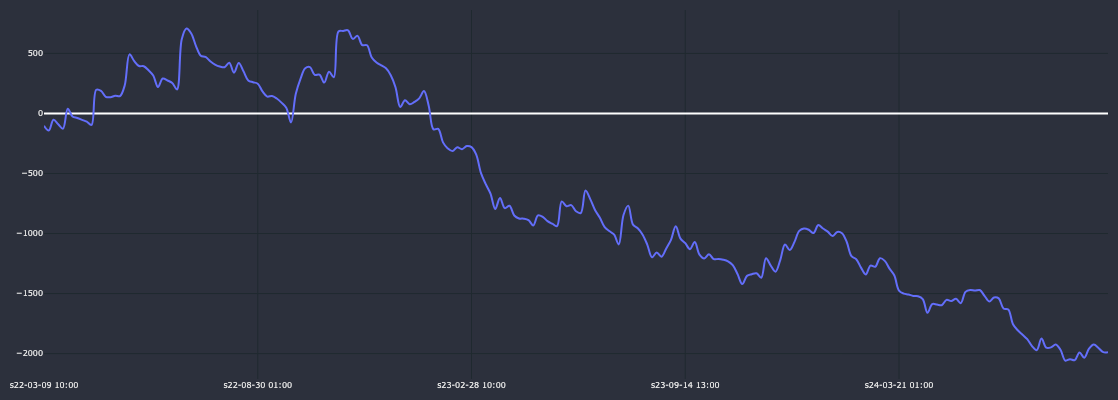

In [116]:
cp = CandlePlot(df_trades, candles=False)
cp.show_plot(line_traces=['GAIN_C'])
# plot shows a huge gain at the end of January 2020
# the time when the covid crises started and everything dropped except the US Dollar
# high pip value due to rise of US Dollar at this time
# doesn't tell much about how effective strategy is